In [1]:
import random
import math
import os
import pickle
from tqdm import tqdm, trange
import numpy as np

import sklearn
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

import pdb

In [2]:
import warnings
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [3]:
from pytorch_pretrained_bert import BertTokenizer

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
def pickler(path,pkl_name,obj):
    with open(os.path.join(path, pkl_name), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def unpickler(path,pkl_name):
    with open(os.path.join(path, pkl_name) ,'rb') as f:
        obj = pickle.load(f)
    return obj

In [6]:
data_pkl_path = "../../data/hotpot_context/"
data_pkl_name = "preprocessed_dev_full_length.pkl"
predictions_pkl_path = "./"
predictions_pkl_name = "predictions.pkl"

max_sentences_per_paragraph = 10

In [7]:
def score(gt, pred):
    assert(len(gt) == len(pred))
    total_size = len(pred)
    assert(len(gt) != 0)
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_correct = 0
    for i in range(total_size):
        if(gt[i] == pred[i]):
            total_correct += 1
        p = precision_score(gt[i], pred[i],average="binary")
        r = recall_score(gt[i], pred[i],average="binary")
        total_precision += p
        total_recall += r
        total_f1 += 2*(p*r)/(p+r) if (p+r)>0 else 0
    return {"precision":total_precision/total_size, "recall":total_recall/total_size, 
            "f1":total_f1/total_size, "em":total_correct/total_size}

In [8]:
dataset = unpickler(data_pkl_path, data_pkl_name)

In [9]:
dataset.keys()

dict_keys(['sequence_0', 'sentence_start_index_0', 'sentence_end_index_0', 'supporting_fact_0', 'segment_id_0', 'sequence_1', 'sentence_start_index_1', 'sentence_end_index_1', 'supporting_fact_1', 'segment_id_1', 'sequence_2', 'sentence_start_index_2', 'sentence_end_index_2', 'supporting_fact_2', 'segment_id_2', 'sequence_3', 'sentence_start_index_3', 'sentence_end_index_3', 'supporting_fact_3', 'segment_id_3', 'sequence_4', 'sentence_start_index_4', 'sentence_end_index_4', 'supporting_fact_4', 'segment_id_4', 'sequence_5', 'sentence_start_index_5', 'sentence_end_index_5', 'supporting_fact_5', 'segment_id_5', 'sequence_6', 'sentence_start_index_6', 'sentence_end_index_6', 'supporting_fact_6', 'segment_id_6', 'sequence_7', 'sentence_start_index_7', 'sentence_end_index_7', 'supporting_fact_7', 'segment_id_7', 'sequence_8', 'sentence_start_index_8', 'sentence_end_index_8', 'supporting_fact_8', 'segment_id_8', 'sequence_9', 'sentence_start_index_9', 'sentence_end_index_9', 'supporting_fact

In [10]:
predictions_raw = unpickler(predictions_pkl_path, predictions_pkl_name)

In [11]:
dataset['document_length'][10]

[4, 7, 5, 11, 1, 3, 4, 2, 6, 5]

In [12]:
predictions_raw.shape

(7344, 100)

In [13]:
dataset['supporting_fact_0'][0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [14]:
predictions_raw[0]

array([ -9.728283 , -10.901839 , -10.997422 , -11.282068 , -11.282068 ,
       -11.282068 , -11.282068 , -11.282068 , -11.282068 , -11.282068 ,
         7.3729033,  -5.776464 ,  -5.9727836, -10.069361 , -10.069361 ,
       -10.069361 , -10.069361 , -10.069361 , -10.069361 , -10.069361 ,
       -11.251507 , -11.267144 , -11.264733 , -11.251424 , -11.252738 ,
       -11.282895 , -11.282895 , -11.282895 , -11.282895 , -11.282895 ,
       -11.100354 , -11.464603 , -11.163882 , -11.180441 , -11.214095 ,
       -11.28501  , -11.28501  , -11.28501  , -11.28501  , -11.28501  ,
         7.393575 , -10.065829 , -10.065829 , -10.065829 , -10.065829 ,
       -10.065829 , -10.065829 , -10.065829 , -10.065829 , -10.065829 ,
       -11.128537 , -11.202582 , -11.212113 , -11.28222  , -11.28222  ,
       -11.28222  , -11.28222  , -11.28222  , -11.28222  , -11.28222  ,
       -11.230548 , -11.234452 , -11.245614 , -11.246818 , -11.247802 ,
       -11.287658 , -11.287658 , -11.287658 , -11.287658 , -11.2

In [15]:
list(range(0,10,5))

[0, 5]

In [16]:
def reorganize_predictions(predictions, document_lengths):
    out_list = []
    for i, pred in enumerate(predictions):
        num_paragraphs = len(document_lengths[i])
        max_sentences_per_para = int(len(pred)/num_paragraphs)
        new_pred = []
        for j,num_sentences in enumerate(document_lengths[i]):
            new_pred += pred[j*max_sentences_per_para : j*max_sentences_per_para + min(max_sentences_per_para, num_sentences)]
        out_list.append(new_pred)
    return out_list
        

def stack_suporting_facts(dataset):
    out_list = []
    data_size = len(dataset['supporting_fact_0'])
    for i in range(data_size):
        num_paragraphs = len(dataset['document_length'][i])
        stacked_sf = []
        for j in range(num_paragraphs):
            stacked_sf += dataset['supporting_fact_{}'.format(j)][i]
        out_list.append(stacked_sf)
    return out_list



def reorganize_predictions_old(predictions, document_lengths):
    out_list = []
    start_index = 0
    for i in range(len(document_lengths)):
        pred_raw = predictions[start_index:start_index+len(document_lengths[i])]
        pred = []
        for j,p in enumerate(pred_raw):
            pred += p[:document_lengths[i][j]]
            pred += [0] * (document_lengths[i][j] - len(p[:document_lengths[i][j]]))
        out_list.append(pred)
        start_index += len(document_lengths[i])
    return out_list

In [17]:
predictions_reorganized = reorganize_predictions(predictions_raw.tolist(), dataset['document_length'])

In [18]:
sf_stacked = stack_suporting_facts(dataset)

In [19]:
supporting_facts_reorganized = reorganize_predictions(sf_stacked, dataset['document_length'])

In [20]:
for i in trange(len(predictions_reorganized)):
    assert(len(supporting_facts_reorganized[i]) == len(predictions_reorganized[i]))

100%|██████████| 7344/7344 [00:00<00:00, 783810.49it/s]


In [21]:
def evaluate(gt, pred_raw, threshold, dataset):
    pred_answer_labels = (torch.sigmoid(torch.tensor(pred_raw)) > threshold).numpy().tolist()
    predictions_reorganized = reorganize_predictions(pred_answer_labels, dataset['document_length'])
    result = score(gt, predictions_reorganized)
    return result
    
    

def evaluate_old(gt, pred, threshold, document_lengths):
    pred_answer_labels = (torch.sigmoid(torch.tensor(pred)) > threshold).numpy().tolist()
    predictions_reorganized = reorganize_predictions(pred_answer_labels, document_lengths)
    supporting_facts_reorganized = reorganize_predictions(gt, document_lengths)
    result = score(supporting_facts_reorganized, predictions_reorganized)
    return result

In [22]:
evaluate(supporting_facts_reorganized, predictions_raw, 0.5, dataset)

{'precision': 0.7713789682539768,
 'recall': 0.8799257897603537,
 'f1': 0.8059427281445529,
 'em': 0.3951525054466231}

In [23]:
metrics = {'precision':[], 'recall':[], 'f1':[], 'em':[]}
for t in tqdm(np.linspace(0.1,1,18,endpoint=False)):
    result = evaluate(supporting_facts_reorganized, predictions_raw, t, dataset)
    for key,value in result.items():
        metrics[key].append(value)

100%|██████████| 18/18 [03:47<00:00, 12.95s/it]


In [24]:
max(metrics['f1'])

0.8139301315363656

In [25]:
max(metrics['em'])

0.48869825708061004

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
metric_df = pd.DataFrame(metrics, index=np.linspace(0.1,1,18,endpoint=False))

In [28]:
metric_df

,precision,recall,f1,em
0.10,0.653884,0.947638,0.748770,0.256808
0.15,0.676514,0.938606,0.763610,0.280365
0.20,0.694969,0.930250,0.774344,0.299973
0.25,0.710927,0.921942,0.782795,0.321623
0.30,0.723859,0.912215,0.788080,0.335920
0.35,0.736662,0.903854,0.793670,0.351580
0.40,0.748195,0.895741,0.798030,0.364924
0.45,0.759820,0.888048,0.802320,0.378676
0.50,0.771379,0.879926,0.805943,0.395153
0.55,0.781775,0.870606,0.808116,0.409450


<Figure size 432x288 with 0 Axes>

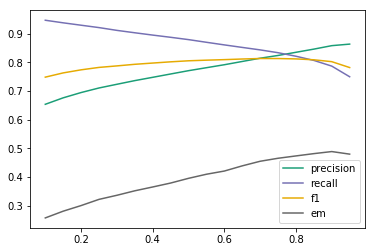

In [29]:
plt.figure(); metric_df.plot(colormap="Dark2");

In [30]:
import seaborn as sns

/home/bhargav/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


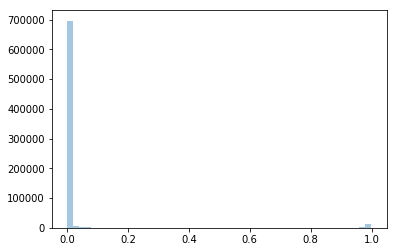

In [31]:
sns.distplot((torch.sigmoid(torch.tensor(predictions_raw))).numpy().flatten(),kde=False, hist=True, rug=False)